In [1]:
import json
import os
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.io import savemat
from statsmodels.formula.api import ols

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.networks import zscore_network

%matplotlib inline
mpl.rcParams['font.size'] = 13

In [2]:
path_derivatives = os.path.join(path_root, 'data/main_fmri_study/derivatives')
path_out = os.path.join(path_derivatives, 'ppi')
path_nistats = os.path.join(path_derivatives, 'nistats')
path_jags = os.path.join(path_derivatives, 'jags')
path_betamats = os.path.join(path_out, 'betamats')
path_parcellations = os.path.join(path_out, 'parcellations')
path_exclusion_csv = os.path.join(path_nistats, 'exclusion/exclusion.csv')
path_betamats_custom_roi = os.path.join(path_betamats, 'customROI')

# Behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# ROI information
df_custom = pd.read_csv(
    os.path.join(path_parcellations, 'custom_roi/custom_roi_table.csv'),
    sep=',')
n_rois = len(df_custom)
n_nets = 2

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

---

In [3]:
# Analysis options
options = {
    'symmetrize': True,
    'zscore': False,
    'regressor_name': 'ppi_out_perr'
}

# Data to load
t_event_psycho = 0
t_event_ppi = 1.5
n_regs = 12
flags = 'binarizedPerr'

In [4]:
dirname_load = '_'.join([
    f'tpsycho-{int(t_event_psycho * 1000)}',
    f'tppi-{int(t_event_ppi * 1000)}',
    f'nRegs-{n_regs}',
    flags
])

# PPI model regressors information
path_data = os.path.join(path_betamats_custom_roi, dirname_load, 
                         'options_betamats.json') 
with open(path_data, 'r') as f:
    options_betamats = json.loads(f.read())


beta_names = options_betamats['regressors_save']
n_regressors = len(beta_names)
beta_idx = beta_names.index(options['regressor_name'])

---

### Load beta matrices

Here, PPI matrices (each "connection" value is actually beta value for PPI GLM model, hence the name `beta_mats`) are loaded and aggregated over subjects and task conditions. Symmetrical version of matrices are created. These symmetrical version are then used to create average within and between subnetwork strenght matrices. 

- `beta_mats_agg`: beta_matrices (shape `n_regressors` $\times$ `n_rois` $\times$ `n_rois)` aggregated over subjects and tasks)
- `beta_mats_agg_trans`: version with beta weights symmetrized for connections `ij` and `ji` 
- `nets_mats_agg_trans`: connection strengths are averaged across subnetworks (↑pe network and ↓pe network)

In [5]:
beta_mats_agg = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
beta_mats_agg_trans = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
nets_mats_agg_trans = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_nets, n_nets))

# Aggregate and transform beta matrices
for con, con_name in enumerate(meta['dim2']):
    for sub, sub_name in enumerate(meta['dim1']):
        
        beta_mats_fname = f'sub-{sub_name}_task-{con_name}_betamats.npy'
        beta_mats = np.load(os.path.join(path_betamats_custom_roi,
                                         dirname_load,
                                         beta_mats_fname))
        
        beta_mats_agg[sub, con] = beta_mats
        
        # Apply transformations
        beta_mats_trans = np.copy(beta_mats)
        
        for b in range(len(beta_mats_trans)):
            np.fill_diagonal(beta_mats_trans[b], val=np.nan)
        
        if options['symmetrize']:
            beta_mats_trans = beta_mats_trans \
                            + np.transpose(beta_mats_trans, (0, 2, 1))
            beta_mats_trans = beta_mats_trans / 2
        
        if options['zscore']:
            for b, beta_mat_trans in enumerate(beta_mats_trans):
                beta_mats_trans[b] = zscore_network(beta_mat_trans)

        
        beta_mats_agg_trans[sub, con] = beta_mats_trans 
        
# Calculate network-level mean values (for transformed beta_mats)
for i, net_i in enumerate(['perr_inc', 'perr_dec']):
    for j, net_j in enumerate(['perr_inc', 'perr_dec']):
        net_i_idx = df_custom[df_custom['netName'] == net_i].index
        net_j_idx = df_custom[df_custom['netName'] == net_j].index
        nets_mats_agg_trans[:, :, :, i, j] = np.nanmean(
            beta_mats_agg_trans[:, :, :, net_i_idx, :][:, :, :, :, net_j_idx], 
            axis=(-1, -2))
        
# Filter excluded subjects
beta_mats_agg = beta_mats_agg[ok_index]
beta_mats_agg_trans = beta_mats_agg_trans[ok_index]
nets_mats_agg_trans = nets_mats_agg_trans[ok_index]
        
# Save to MATLAB file for further NBS use
path_nbs = os.path.join(path_betamats_custom_roi, dirname_load, 'nbs')
Path(path_nbs).mkdir(exist_ok=True)
nbs_beta_mats = np.concatenate((beta_mats_agg_trans[:, 0, beta_idx, :, :], 
                                beta_mats_agg_trans[:, 1, beta_idx, :, :]),
                               axis=0)
nbs_beta_mats = np.transpose(nbs_beta_mats, axes=[1, 2, 0])
savemat(os.path.join(path_nbs, 'nbs_betamats.mat'),
        {'nbs_beta_mats': nbs_beta_mats})

print('beta_mats_agg_trans.shape:', beta_mats_agg_trans.shape)
print('nets_mats_agg_trans.shape:', nets_mats_agg_trans.shape)
print('nbs_beta_mats.shape:', nbs_beta_mats.shape)

beta_mats_agg_trans.shape: (29, 2, 3, 14, 14)
nets_mats_agg_trans.shape: (29, 2, 3, 2, 2)
nbs_beta_mats.shape: (14, 14, 58)


## Question 1
---
Test whether within and between subnetworks strenght depends on subnetwork type and task condition.  

,sum_sq,df,F,PR(>F)
C(condition),0.000113,1.0,0.489064,0.485312
C(net),0.000129,2.0,0.278676,0.757134
C(condition):C(net),0.001009,2.0,2.187730,0.115357
Residual,0.038753,168.0,NaN,NaN


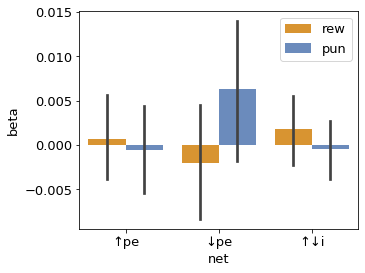

In [6]:
data = []
nets_dict = {'↑pe': (0, 0), '↓pe': (1, 1), '↑↓i': (1, 0)}
if not options['symmetrize']:
    nets_dict.update({'↓↑i': (0, 1)})

for sub, sub_name in enumerate(df_exclusion.loc[ok_index, 'sub']):
    for con, con_name in enumerate(meta['dim2']):
        for net, netidx in nets_dict.items():
            data.append(
                [
                    nets_mats_agg_trans[sub, con, beta_idx, netidx[0], netidx[1]],
                    sub_name,
                    con_name,
                    net
                ]
            )
            
df = pd.DataFrame(data, columns=['beta', 'sub_name', 'condition', 'net'])

# Two-way ANOVA
model = ols('beta ~ C(condition) + C(net) + C(condition):C(net)', data=df).fit()
df_anova = sm.stats.anova_lm(model, typ=2)

# Figure 
fig, ax = plt.subplots(figsize=(5, 4))
bp = sns.barplot(
    x='net', 
    y='beta', 
    hue='condition',
    data=df,
    ax=ax,
    palette={'rew': '#f49915', 'pun': '#5E88CA'}
)
plt.legend(loc='upper right')

df_anova

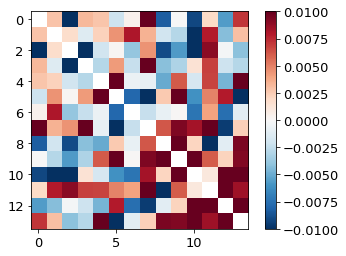

In [7]:
mean_rew = np.mean(beta_mats_agg_trans[:, 0, beta_idx, :, :], axis=0)
mean_pun = np.mean(beta_mats_agg_trans[:, 1, beta_idx, :, :], axis=0)           
                   
plt.imshow(mean_pun, clim=[-0.01, 0.01], cmap='RdBu_r')
plt.colorbar()

In [9]:
len(df)

174